# Generating the Southern Ocean and Antarctic Cap grid

# Generating a southern cap displaced pole grid

Here we present the algorithm and code for generating a compute grid for the Antarctic region with the south pole displaced by a given amount. The reason for displacing the pole is to map it as far as possible from the two biggest ice shelves on the continent (__[Ross and Ronne](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c0/Antarctica.svg/907px-Antarctica.svg.png)__) to have a viable compute grid over them. We generate the grid starting from a usual lat-lon grid on the sphere followed by a series of transformations from the spherical surface of the Earth to a tangent plane at the south pole[^Murray2006],[^Xu2015] . Particularly the displacement of the pole is accomplished via a conformal mapping in the tangent plane [^Marsdenbook]. 


## Grid Parameters

-  $\phi_{SO}$:   ending latitude of the southern ocean grid
-  $\phi_{join}$: starting latitude of the antarctic cap grid (the join). Here we assume $\phi_{join}=\phi_{SO}$
-  $\lambda_{dp}$: longitude of the displaced pole
-  $\phi_{dp}$:  the latitude of the displaced pole  
-  $r_{dp}$:     the fractional distance of the displaced pole from the geographic pole in units of $\tan(90+\phi_{join})$ 



## Algorithm

-  Generate a regular lat-lon grid with desired resolution covering the Earth south of $\phi_{join} = \phi_{SO}$ , $(\lambda,\phi)$ .
-  Project the lat-lon grid to a plane tangent at the south pole (simple gnomonic projection)(not conformal) to planar polar coordinates: 
\begin{align}
r &= R_E \tan(90+\phi)) \\
\theta &= \lambda-\lambda_p
\end{align}

-  Rescale $r$ so that the parallel at  $\phi_{join}$ maps to the unit circle
\begin{align}
r &= R_E \tan(90+\phi)/r_{join} ;\ \ r_{join}\equiv\tan(90+\phi_{join}) \\
\end{align}

-  Use the inverse conformal map to transform $\theta$ so that the angular resolution at the unit circle in $w$-plane (see the next step) matches the corresponding resolution in $z$-plane (which matches the longitudinal resolution at the joint) :   
\begin{align}
z_0 &= r_{dp} e^{i\lambda_p} \\
e^{i\theta'} &= w^{-1}(e^{i\theta}) = \frac{e^{i\theta}+z_0}{1+z_0^* e^{i\theta}}
\end{align}

-  Define
\begin{align}
z=r e^{i\theta'}
\end{align}

-  Do a conformal transformation to map the unit disk to a unit disk with a displaced center:
\begin{align}
w = \frac{z-z_0}{1-z_0^* z}
\end{align}

-  Project back to the sphere tangent at the geographical south pole to form the desired curvilinear coordinates:
\begin{align}
\lambda_c &= \arg(w)\\
\phi_c &= \tan^{-1}\left( |w| r_{join} \right) - 90
\end{align}


Murray2006: __[Roberts, J. L., Heil, P., Murray, R. J., Holloway, D. S., and Bindoff,
N. L.: Pole relocation for an orthogonal grid: An analytic method,
Ocean Model., 12, 16–31, doi:10.1016/j.ocemod.2005.03.004,
2006.](https://doi.org/10.1016/j.ocemod.2005.03.004)__

Xu2015: __[ Xu, S., Wang, B., and Liu, J.: On the use of Schwarz–Christoffel conformal mappings to the grid generation for global ocean models, Geosci. Model Dev., 8, 3471-3485, https://doi.org/10.5194/gmd-8-3471-2015, 2015.](https://doi.org/10.5194/gmd-8-3471-2015)__

Marsdenbook: Basic Complex Analysis, J.E. Marsden, M.J. Hoffman, 2nd Edition, p.355.


## Implementation

### helper routines and constants

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Constants
PI_180 = np.pi/180.
Re = 6.378e6

def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r'):
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
#plot_mesh_in_latlon(lams,phis,stride=16)
def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r'):
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color)
#plt.figure(figsize=(6,6))
#plot_mesh_in_xyz(lams, phis, stride=20)

def mdist(x1,x2):
  """Returns positive distance modulo 360."""
  a=np.mod(x1-x2+720.,360.)
  b=np.mod(x2-x1+720.,360.)
  d=np.minimum(a,b)
  return d

def generate_grid_metrics(x,y,axis_units='degrees'):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
    return dx,dy,area,angle_dx


def write_nc(x,y,dx,dy,area,angle,axis_units='degrees',fnam=None,format='NETCDF3_CLASSIC'):
    import netCDF4 as nc

    if fnam is None:
      fnam='supergrid.nc'
    f=nc.Dataset(fnam,'w',format=format)
    dims=[]
    vars=[]
    nytot,nxtot = y.shape
    nyp=f.createDimension('nyp',nytot)
    nxp=f.createDimension('nxp',nxtot)
    ny=f.createDimension('ny',nytot-1)
    nx=f.createDimension('nx',nxtot-1)    
    yv=f.createVariable('y','f8',('nyp','nxp'))
    xv=f.createVariable('x','f8',('nyp','nxp'))    
    yv.units=axis_units
    xv.units=axis_units 
    yv[:]=y
    xv[:]=x
    dyv=f.createVariable('dy','f8',('ny','nxp'))
    dyv.units='meters'
    dyv[:]=dy
    dxv=f.createVariable('dx','f8',('nyp','nx'))
    dxv.units='meters'
    dxv[:]=dx
    areav=f.createVariable('area','f8',('ny','nx'))
    areav.units='m2'
    areav[:]=area
    anglev=f.createVariable('angle_dx','f8',('nyp','nxp'))
    anglev.units='degrees'
    anglev[:]=angle            
    f.sync()
    f.close()

def generate_latlon_grid(lni,lnj,llon0,llen_lon,llat0,llen_lat):
    llonSP = llon0 + np.arange(lni+1) * llen_lon/lni
    llatSP = llat0 + np.arange(lnj+1) * llen_lat/lnj
    llamSP = np.tile(llonSP,(lnj+1,1)) 
    lphiSP = np.tile(llatSP.reshape((lnj+1,1)),(1,lni+1)) 
    return llamSP,lphiSP
    

### grid parameters

In [214]:
# Specify the grid properties

# All
# Specify the desired resolution
degree_resolution_inverse = 4 #quarter degree grid
refine=2    # Set to 2 for supergrid
lenlon=360  # global longitude range
lon0=-300.  # Starting longitude (longitude of the Northern bipoles)
Ni = lenlon*refine*degree_resolution_inverse

#Mercator grid
lat0_Merc=-65.0  # This is a nominal starting latitude for Mercator grid
lenlat_Merc=125  # nominal latitude range of Mercator grid
# Specify approximate latitude range
#phi_s, phi_n = lat0_M,lat0_M+lenlat_M
# To reproduce MIDAS we need to change these to the values produced by MIDAS 
phi_s_Merc, phi_n_Merc = -66.85954724706843, 64.0589597296948

#Southern grid
Nj_SO=110*refine
lat0_SO=-78.0
lenlat_SO = phi_s_Merc-lat0_SO 

#Southern cap
Nj_scap=80*refine
Nj_ncap=240*refine
lon0_Scap=100.0
r0_Scap=0.20
doughnut=0.12


### Implementation of the algorithm

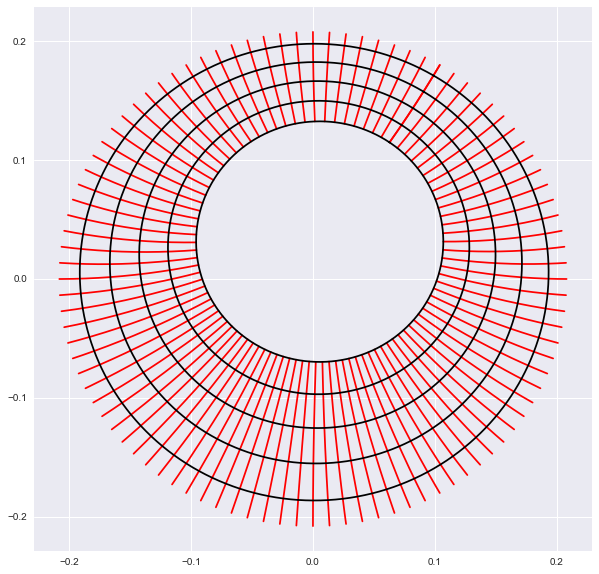

In [224]:

def displaced_pole_cap(lon_grid,lat_grid,lam_pole,r_pole,lat_joint,excluded_fraction=None):

    #Projection from center of globe to plane tangent at south pole
    r_joint = np.tan((90+lat_joint)*PI_180) 
    z_0= r_pole * np.exp(1j*lam_pole*PI_180) 

    r = np.tan((90+lat_grid) *PI_180)/r_joint

    #Find the theta that has matching resolution at the unit circle with longitude at the joint
    #This is a conformal transformation the unit circle (inverse to the one below)
    e2itheta = np.exp(1j*lon_grid*PI_180) 
    e2ithetaprime = (e2itheta + z_0)/(1. + np.conj(z_0)*e2itheta)

    #Conformal map to displace pole from r=0 to r=r_dispole
    z=r*e2ithetaprime
    w=(z-z_0)/(1-np.conj(z_0)*z)
    
    #Inverse projection from tangent plane back to sphere
    lamcDP = np.angle(w, deg=True)
    rw=np.absolute(w)
    phicDP = -90+np.arctan(rw*r_joint)/PI_180
    if excluded_fraction is not None:
        ny,nx = lon_grid.shape 
        jmin=np.ceil(excluded_fraction*ny)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return lamcDP[jmint:,:], phicDP[jmint:,:]
    else:
        return lamcDP,phicDP

    
x=lamSO[0,:]
y=np.linspace(-90.,0.5*(lat0_SO-90.0),Nj_scap//8)
y=np.concatenate((y,np.linspace(y.max(),lat0_SO,7*Nj_scap//8+1)))
X1,Y1=np.meshgrid(x,y)
#print("X1.shape,Y1.shape ",X1.shape,Y1.shape)
    
lamc_DP,phic_DP = displaced_pole_cap(X1,Y1,lam_pole=-lon0_Scap,r_pole=r0_Scap,lat_joint=lat0_SO,
                                     excluded_fraction=doughnut)   
    
#plot grid
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamc_DP,phic_DP, stride=30)

# Generate the Southern Ocean regular lat-lon grid

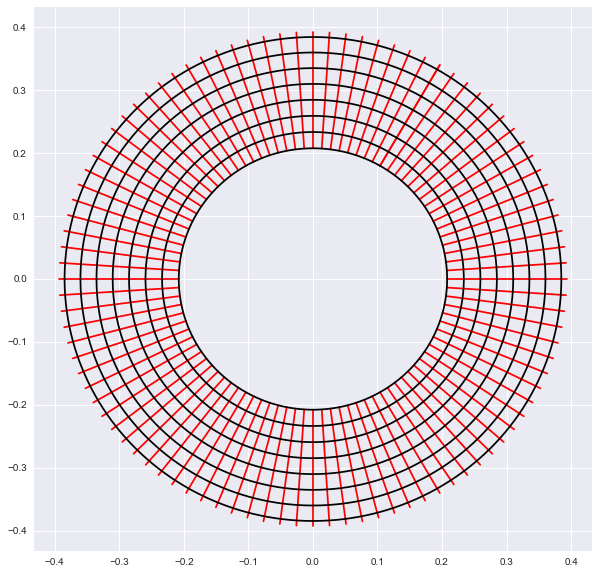

In [225]:
lamSO,phiSO = generate_latlon_grid(Ni,Nj_SO,lon0,lenlon,lat0_SO,lenlat_SO)
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamSO,phiSO, stride=30)

## Together

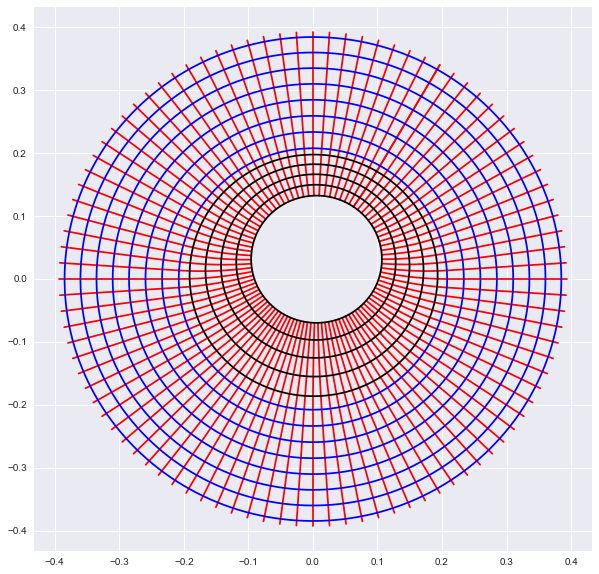

In [226]:
plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamc_DP,phic_DP, stride=30,phi_color='k', lam_color='r')
plot_mesh_in_xyz(lamSO,phiSO, stride=30,phi_color='b', lam_color='r')

# Generating a southern cap displaced pole grid via package MIDAS

The code snippet below uses the MIDAS package to generate the souther cap displaced pole grid.


On  Sep 4, 2012, Bob Hallberg wrote:

  I believe that the conformal mapping that we want to use for our global ocean coupled to an Antarctic ice-sheet, which maps a circle of radius 1 onto a circle of the same radius but a displaced center is

  w = (z - a) / (1 - z a*),

where w, z and a are all complex numbers with magnitudes smaller than or equal to 1, and the pole at the origin is remapped to -a. Here w would be our actual coordinate, while z is our grid-space coordinate.

The following is the MIDAS implementation for the above vision.

ending latitude =  -78.0
applying a conformal remapping of the pole, original  radius =  12.0  degrees
displaced pole location (relative to unit sphere) =  0.2
displaced pole angle ( clockwise degrees relative to Greenwich) =  80.0
excluding inner  12.0  percent of the grid
phiSDP.shape= (141, 2881)
lamSDP.shape= (141, 2881)


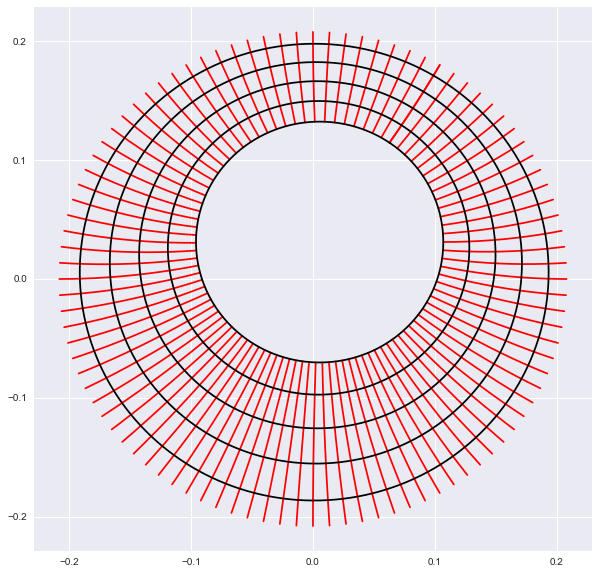

In [64]:
#phiSDP,lamSDP = displaced_pole_MIDAS(X,Y,r0_Scap,lon0_Scap,excluded_fraction=doughnut)
def displaced_pole_MIDAS(x,y,ra2,phia,excluded_fraction=None,pole=-1,verbose=True):
    """
    Displace the pole of the grid to (ra2,phia) with an option
    to exclude a portion of the grid nearest the pole
    """
    
    if pole == -1:
      radius = 90.+y[-1,0]
      r=(90.0+y)/radius
      print ('ending latitude = ', y[-1,0]     )
    else:  # Did not test this option yet (probably does not work)
      radius = 90.-y[0,0]
      r=(90.0-y)/radius
      print ('ending latitude = ',y[0,0])
    ra=ra2

    if verbose:
      print ('applying a conformal remapping of the pole, original  radius = ',radius, ' degrees')
      print ('displaced pole location (relative to unit sphere) = ',ra)
      print ('displaced pole angle ( clockwise degrees relative to Greenwich) = ', -phia+180.)

      if excluded_fraction is not None:
        print ('excluding inner ',excluded_fraction*100.,' percent of the grid')

    a=np.complex(ra2*np.cos(PI_180*-phia),ra2*np.sin(PI_180*-phia))

    phi=x

    lon0 = phi[0,0]

    ny,nx=x.shape

    theta_chg=np.arccos(2.0*ra/(1.0+ra*ra))
    r_out=np.zeros(phi.shape)
    phi_out=np.zeros(phi.shape)

    for j in np.arange(phi.shape[0]):
      for i in np.arange(phi.shape[1]):

        th_1 = (phi[j,i]+phia)*PI_180
        if th_1 > np.pi:
          th_1=th_1-2.0*np.pi
        elif th_1 < -np.pi:
          th_1 = th_1+2.0*np.pi

        theta=th_1.copy()
        if np.abs(np.sin(th_1)) <= 0.5*np.abs(np.cos(th_1)):
          tan_tgt = np.tan(th_1)
          if th_1 >= 0.0:
            if tan_tgt >= 0.0:
              th_min = 0.0; th_max = theta_chg
            else:
              th_min = theta_chg ; th_max = np.pi
          else:
            if tan_tgt <= 0.0:
              th_max = 0.0 ; th_min = -theta_chg
            else:
              th_max = -theta_chg ; th_min = -np.pi
          if np.logical_or(theta>th_max,theta<th_min):
            theta = 0.5*(th_max+th_min)

          for ii in np.arange(20):
            denom =  np.cos(theta)*(1.+ra*ra) - 2.0*ra;
            val = np.sin(theta)*(1.-ra*ra) / denom;
            dval_dth = ((1.-ra**4) - 2.0*ra*(1.-ra**2)*np.cos(theta) ) / denom**2;
            err = val - tan_tgt;
            if np.abs(err) < 1e-12:
              break
            theta_prev = theta.copy();
            theta = theta - err / dval_dth;
            if theta > th_max:
              theta = 0.5*(theta_prev+th_max)
            if theta < th_min:
              theta = 0.5*(theta_prev+th_min)
        else:
          if th_1==0.0:
            cot_tgt=0.0
          else:
            cot_tgt = 1.0/np.tan(th_1)

          if th_1>=0.0:
            if cot_tgt >=0.0:
              th_min = 0.0; th_max = theta_chg.copy()
            else:
              th_min = theta_chg.copy() ; th_max = np.pi
          else:
            if cot_tgt<=0.0:
              th_max = 0.0
              th_min = -theta_chg
            else:
              th_max = -theta_chg
              th_min = -np.pi
          if np.logical_or(theta>th_max,theta<th_min):
            theta = 0.5*(th_max+th_min)


          for ii in np.arange(20):
            denom = np.sin(theta)*(1.0-ra*ra)
            val=(np.cos(theta)*(1.0+ra*ra) - 2.0*ra)/denom
            dval_dth = (-(1.0-ra**4.0) + 2.0*ra*(1.0-ra**2.0)*np.cos(theta)) / denom**2.
            err = val -  cot_tgt
            if np.abs(err) < 1.e-12:
              break
            theta_prev=theta.copy()
            theta = theta - err / dval_dth
            if theta>th_max:
              theta=0.5*(theta_prev+th_max)
            if theta<th_min:
              theta=0.5*(theta_prev+th_min)

        th_cor = theta-phia*PI_180
        z=np.complex(r[j,i]*np.cos(th_cor),r[j,i]*np.sin(th_cor))
        w = (z-a)/(1.0-z*np.conj(a))
        r_out[j,i]=np.abs(w)
        phi_out[j,i]=np.angle(w)/PI_180

    r_out=-90.0+r_out*radius

    for j in np.arange(0,phi_out.shape[0]):
      tmp=np.squeeze(phi_out[j,:])
      tmp0=tmp[0]
      if tmp0>0.:
        tmp0=tmp0-360.
      tmp[0]=tmp0
      for i in np.arange(1,phi_out.shape[1]):
        dtmp=tmp[i]-tmp[i-1]
        if dtmp > 360.:
          tmp[i]=tmp[i]-360.
        elif dtmp < -360:
          tmp[i]=tmp[i]+360.
      phi_out[j,:]=tmp[:]

    jmin=0;jmax=ny
    if excluded_fraction is not None:
      if pole == -1:
        jmin=np.ceil(ny*excluded_fraction)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return r_out[jmint:,:], phi_out[jmint:,:]
      else:
        jmax=np.ceil(ny*(1.0 - excluded_fraction))
        return r_out[:jmax,:], phi_out[:jmax,:]
    else:
      return r_out,phi_out


x=lamSO[0,:]
y=np.linspace(-90.,0.5*(lat0_SO-90.0),Nj_scap//8)
y=np.concatenate((y,np.linspace(y.max(),lat0_SO,7*Nj_scap//8+1)))
X,Y=np.meshgrid(x,y)

phiSDP,lamSDP = displaced_pole_MIDAS(X,Y,r0_Scap,lon0_Scap,excluded_fraction=doughnut)
print ('phiSDP.shape=',phiSDP.shape)
print ('lamSDP.shape=',lamSDP.shape)

plt.figure(figsize=(10,10))
plot_mesh_in_xyz(lamSDP, phiSDP, stride=30)